**Task 1. Ukrainian Text Generation**

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import re

In [32]:
#Завантажимо файл
from google.colab import files
uploaded = files.upload()

Saving Lys_mykyta.txt to Lys_mykyta (1).txt


In [33]:
#Перевіримо, чи текст коректно читається
filename = list(uploaded.keys())[0]
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read().lower()
    print(text[:500])

казка.укр - дитячі книги з малюнками 
українською мовою онлайн
іван франко
лис микита
за редакцією максима рильского
ілюстрації – с.артюшенко


пісня перша
надійшла весна прекрасна,
многоцвітна, тепла, ясна,
мов дівчина у вінку;
ожили луги, діброви,
повно гамору, розмови
і пісень в чагарнику.

лев, що цар є над звірами,
пише листи з печатками,
розсилає на весь світ:
в тих листах велить він строго,
щоб посходився до нього
в мить увесь звірячий рід.

ось ідуть вони юрбами –
ті безхвості, ті з хвос


In [34]:
# Очищення тексту (залишаємо лише українські символи)
text = re.sub(r'[^а-яєґії]', ' ', text)

# Унікальні символи в тексті
chars = sorted(set(text))
char2idx = {c: i for i, c in enumerate(chars)}
idx2char = {i: c for i, c in enumerate(chars)}

# Перетворення тексту в послідовності чисел
seq_length = 100
sequences = []
next_chars = []
for i in range(0, len(text) - seq_length):
    sequences.append([char2idx[c] for c in text[i:i + seq_length]])
    next_chars.append(char2idx[text[i + seq_length]])

x = np.array(sequences)
y = tf.keras.utils.to_categorical(next_chars, num_classes=len(chars))

In [39]:
# Побудова моделі
model = tf.keras.Sequential([
    layers.Embedding(input_dim=len(chars), output_dim=256),
    layers.Bidirectional(layers.LSTM(512, return_sequences=True)),
    layers.Dropout(0.3),  # Dropout для регуляризації
    layers.LSTM(512),
    layers.Dropout(0.3),
    layers.Dense(len(chars), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [40]:
# Перевірка доступності GPU
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print("Using device:", device)

Using device: /GPU:0


In [47]:
# Функція для обчислення перплексії
def perplexity(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(cross_entropy))

In [42]:
# Навчання моделі з EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3)

with tf.device(device):
    history = model.fit(x, y, batch_size=64, epochs=20, callbacks=[early_stop])

Epoch 1/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 133s 96ms/step - loss: 2.6420
Epoch 2/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 129s 96ms/step - loss: 2.1417
Epoch 3/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 129s 96ms/step - loss: 1.9100
Epoch 4/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 129s 96ms/step - loss: 1.7623
Epoch 5/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 129s 96ms/step - loss: 1.6455
Epoch 6/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.5523
Epoch 7/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.4564
Epoch 8/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.3690
Epoch 9/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.2970
Epoch 10/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.2186
Epoch 11/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.1635
Epoch 12/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.1063
Epoch 13/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - loss: 1.0444
Epoch 14/20
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 130s 96ms/step - 

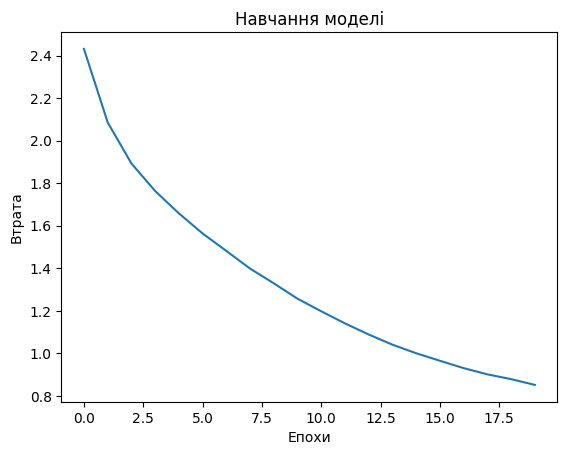

In [43]:
# Візуалізація втрат
plt.plot(history.history['loss'])
plt.xlabel('Епохи')
plt.ylabel('Втрата')
plt.title('Навчання моделі')
plt.show()

In [48]:
# Виведення перплексії
y_pred = model.predict(x)
perplexity_score = perplexity(tf.convert_to_tensor(y), tf.convert_to_tensor(y_pred))
print(f"Перплексія моделі: {perplexity_score.numpy()}")

2701/2701 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step
Перплексія моделі: 1.6950019598007202


In [49]:
# Функція для генерації тексту
def generate_text(seed_text, length, temperature=1.0):
    generated = seed_text
    for _ in range(length):
        # Перевірка довжини seed
        if len(generated) < seq_length:
            generated = generated.rjust(seq_length)
        try:
            input_seq = np.array([[char2idx[c] for c in generated[-seq_length:] if c in char2idx]])
        except KeyError:
            break

        preds = model.predict(input_seq)[0]
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_idx = np.random.choice(len(chars), p=preds)
        generated += idx2char[next_idx]
    return generated

In [50]:
# Приклад генерації
seed = "Микита"
generated_text = generate_text(seed, length=500, temperature=0.5)
print(generated_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━